In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from copy import deepcopy
import re
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



### Reading data into Pandas
I decided to read the most frequent csv dataset for this project. The data is from teh 2014-2015 school year

In [302]:
df = pd.read_csv("Desktop/CollegeScorecard_Raw_Data/MERGED2011_12_PP.csv")

### Preprocessing round 1
- remove features with only null values
- remove features with only 1 value across all obs
- turn certain features values into the string values that they represent (ie. `HIGHDEG`) is suppose to represent the highest degree awarded

In [303]:
def drop_svf(df):
    '''
    drop single value features (where all observations in that column have only 1 value)
    df : dataframe 
    return : dataframe
    '''
    df_cleaned = deepcopy(df)
    for column in df.columns:
        if len(df[column].value_counts()) == 1:
            df_cleaned = df_cleaned.drop(column, axis = 1)
    return df_cleaned

def replace_category(df, col_name, name_key):
    '''
    replace the integer/float representation of values in a column 
    by the corresponding string values of name_key
    
    df : dataframe to operate on
    col_name : a list of column names of which the replacement will take place
    name_key : the corresponding replacement list of strings to which each of the values 
               in col_name will be replaced by
               
    return : the newly modified dataframe
    '''
    new_df = df.copy()
    for col in col_name:
#         assert str(df[col].dtype) == 'float64' or str(df[col].dtype) == 'int64'
        new_col = []
        for i,obs in enumerate(df[col]):
            if np.isnan(obs):
                str_val = np.nan
            else:
                str_val = name_key[int(obs)]
            new_col.append(str_val)
        new_df[col] = new_col
    return new_df

In [304]:
df = df.dropna(axis = 1, how='all')
df = drop_svf(df)
df.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,SCH_DEG,MAIN,NUMBRANCH,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,3.0,1,1,...,NaN,0.000000,1088.0,NaN,NaN,1,0.4786,0.5214,1514.0,1438.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,3.0,1,1,...,NaN,0.283168,1515.0,NaN,NaN,1,0.4154,0.5846,2836.0,3160.0
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,3.0,1,1,...,NaN,0.000000,4.0,NaN,NaN,1,0.4389,0.5611,315.0,266.0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,3.0,1,1,...,NaN,0.348243,626.0,NaN,NaN,1,0.5402,0.4598,1083.0,1208.0
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,3.0,1,1,...,NaN,0.000000,1198.0,NaN,NaN,1,0.4054,0.5946,2045.0,1957.0


In [306]:
deg_name = ['not classified','certificate','associate','bachelor','graduate']
control_name = ['','public', 'private_nonprofit', 'private_for-profit']
region_name = ['us_service_schools', 'new_england', 'mid_east', 'great_lakes', 'plains',
               'southeast', 'southwest', 'rocky_mountains', 'far_west', 'outlying_areas']
iclevel_name = ['','4_year','2_year','less_than_2_year']

# df = replace_category(df, ['HIGHDEG','PREDDEG'], deg_name)
# df = replace_category(df, ['CONTROL'], control_name)
# df = replace_category(df, ['REGION'], region_name)
# df = replace_category(df, ['ICLEVEL'], iclevel_name)



### College University subset (Preprocessing round 2)

- I am going to begin my analysis first with schools that have undergraduate students enrolled
- I am going to drop certian redundant and unnecessary features (mostly names, zip codes, ids)
- I am going to drop observation with more than 40% null values to insure quaity of our observations when we impute missing features later


In [307]:
def remove_row_missing(df, threshold):
    '''
    remove observations in df that has more than threshold% of null values
    
    df : a dataframe
    threshold : the cuttoff ratio of unavailable data that will dictate the dropping of an observation
    
    return : a new dataframe with observations dropped
    '''
    new_df = df.copy()
    length = len(df.columns)
    
    for i, row in df.iterrows():
        num_nans = row.isnull().sum()
        
        ratio = num_nans / length
        
        if ratio > threshold:
            new_df.drop(i, inplace = True)
            
    return new_df.reset_index(drop=True)


In [308]:
df_college = df[df.UGDS > 0].reset_index(drop='True')
df_college = df_college.drop(['OPEID','INSTNM','CITY','ZIP','OPEID6','ST_FIPS',
                              'SCH_DEG','STABBR','REPAY_DT_MDN','ALIAS'], axis = 1)
df_college = remove_row_missing(df_college, 0.8)
df_college.head()

,UNITID,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,REGION,ADM_RATE,ADM_RATE_ALL,SATVR25,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,1,1,bachelor,graduate,public,southeast,0.5010,0.5010,370.0,...,NaN,0.000000,1088.0,NaN,NaN,4_year,0.4786,0.5214,1514.0,1438.0
1,100663,1,1,bachelor,graduate,public,southeast,0.7223,0.7223,500.0,...,NaN,0.283168,1515.0,NaN,NaN,4_year,0.4154,0.5846,2836.0,3160.0
2,100690,1,1,bachelor,graduate,private_nonprofit,southeast,NaN,NaN,NaN,...,NaN,0.000000,4.0,NaN,NaN,4_year,0.4389,0.5611,315.0,266.0
3,100706,1,1,bachelor,graduate,public,southeast,0.6368,0.6368,500.0,...,NaN,0.348243,626.0,NaN,NaN,4_year,0.5402,0.4598,1083.0,1208.0
4,100724,1,1,bachelor,graduate,public,southeast,0.5080,0.5080,360.0,...,NaN,0.000000,1198.0,NaN,NaN,4_year,0.4054,0.5946,2045.0,1957.0


In [309]:
df_college.shape

(7042, 1575)

### Deciding on which features to predict
I am going to predict mean income after graduation from these schools. Since I am interested in the longer term mean earnings for graduates, I will be trying to predict `MN_EARN_WNE_P10`. Moreoever, there will generally more variabilty for earnings data the more years after graduation, possibly giving us more interesting results.

- I will then remove all features that are other ways to represent earning information (ie. `MN_EARN_WNE_P6`)  because they are basically the same measure as my target variable.
- I will also remove all information regarding repayment since that is also highly related to our target variable, diminishing the task of this project, which is to use static school information to predict post graduation earnings

In [310]:
# list of column names on earnings that will be removed due to relationship with MN_EARN_WNE_P10
loe = list(df_college.columns[df_college.columns.to_series().str.contains('_EARN_')][1:])
loe.extend(list(df_college.columns[df_college.columns.to_series().str.contains('GT_')]))

# list of column names on repayment that will be removed due too strong og a relationship with MN_EARN_WNE_P10
lor = list(df_college.columns[df_college.columns.to_series().str.contains('RPY')])

# list of column names on repayment that will be removed due too strong og a relationship with MN_EARN_WNE_P10
lod = list(df_college.columns[df_college.columns.to_series().str.contains('DEBT')])

df_college = df_college.drop(loe, axis = 1)
df_college = df_college.drop(lor, axis = 1)
df_college = df_college.drop(lod, axis = 1)
df_college.head()

,UNITID,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,REGION,ADM_RATE,ADM_RATE_ALL,SATVR25,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,1,1,bachelor,graduate,public,southeast,0.5010,0.5010,370.0,...,NaN,0.000000,1088.0,NaN,NaN,4_year,0.4786,0.5214,1514.0,1438.0
1,100663,1,1,bachelor,graduate,public,southeast,0.7223,0.7223,500.0,...,NaN,0.283168,1515.0,NaN,NaN,4_year,0.4154,0.5846,2836.0,3160.0
2,100690,1,1,bachelor,graduate,private_nonprofit,southeast,NaN,NaN,NaN,...,NaN,0.000000,4.0,NaN,NaN,4_year,0.4389,0.5611,315.0,266.0
3,100706,1,1,bachelor,graduate,public,southeast,0.6368,0.6368,500.0,...,NaN,0.348243,626.0,NaN,NaN,4_year,0.5402,0.4598,1083.0,1208.0
4,100724,1,1,bachelor,graduate,public,southeast,0.5080,0.5080,360.0,...,NaN,0.000000,1198.0,NaN,NaN,4_year,0.4054,0.5946,2045.0,1957.0


### Removing features with too many nulls and privacy supressed columns and replace null values in each column by 0 (Preprocessing round 3)

- I am also going to drop features that have more than 20% missing data as imputation later will be troublesome with so much missing values.
- I am going to replace values in ordinal features will with 0 and create another binary value feature right after it indicating whether whether the corresponding value in the previous feature has nan.

For categorical variables I can do the same because having null value for that observation inidicates the absence of its categorical quality, which is itself a category, a quality.

In [311]:
def remove_col_missing(df, threshold):
    '''
    remove features in df that has more than threshold% of null values + privacy suppressed values
    
    df : a dataframe
    threshold : the cuttoff ratio of unavailable data that will dictate the dropping of an features
    
    return : a new dataframe with features dropped
    '''
    new_df = df.copy()
    length = len(df)
    
    for col in list(df.columns):
        num_nans = df[col].isnull().sum()
        ps = list(df[col]).count('PrivacySuppressed')
        
        ratio = (num_nans + ps) / length
        
        if ratio > threshold and col != 'MN_EARN_WNE_P10':
            new_df.drop(col, axis = 1, inplace = True)
            
    return new_df.reset_index(drop=True)


# let us create the binary features first
def create_null_indicator(df):
    '''
    for every column in the dataframe with null values in it, create another 0/1 binary column 
    right after it indicating whether the corresponinf row obs in the previous column is null
    
    df : a dataframe
    return : a dataframe with additional columns created
    '''
    new_df = df.copy()
    
    for i in range(len(df.columns)):
        
        if not df[df.columns[i]].isnull().values.any():
            continue
            
        null_indicator = []
        
        for obs in df[df.columns[i]]:
            # np.nan == np.nan will yield false
            if obs == obs:
                null_indicator.append(0)
            else:
                null_indicator.append(1)
                
        col_name = str(df.columns[i]) + '_ISNULL'
        index = list(new_df.columns).index(df.columns[i])
        
        new_df.insert(index + 1, column = col_name, value = np.array(null_indicator))
    return new_df

In [312]:
df_college = remove_col_missing(df_college, 0.6)
df_college = create_null_indicator(df_college)
df_college.fillna(0, inplace=True)


### Writing out file for imputation

In [317]:
df_college.to_csv('df_college3.csv',index=False,)

### Privacy suppressed columns

After dealing with the null values, we still have privacy suppressed values in the dataset to handle. However, for these values, we can be sure that they exist but has been suppressed due to privacy issues usally for small schools with less people. Therefore, imputing them would be more acceptable than imputing missing values where we are not even able to determine whether its missing or do not apply

I applied Multiple Imputation Chained Equation on the dataset for privacy suppressed value. SInce python does not have a good enough imputation package that support this method, I did the imputation in R. Now I am reading back the 5 completed imputed dataset into pandas

In [2]:
chunks = pd.read_csv('imputed2.csv',chunksize=6750,)

In [3]:
completed_dfs = []
for chunk in chunks:
    completed_dfs.append(pd.DataFrame(chunk).reset_index(drop=True))
completed_dfs = completed_dfs[1:]

### Remove some collinear features

When I was runnign the imputation in R, part of what the algorithm did was to drop features in teh imputation process that it deemed strongly collinear to one of the other features. Therefore, certain features still have NAs in them. We will take adavantage of this singal indicating that the correspoding feature is collinear to some other feature and can therefore be dropped without sacrificing our modeling power later on.

In [4]:
def remove_collinear_col(dfs):
    '''
    remove columns in all dataframe that has null values in them
    
    dfs : list of dataframes
    return : list of dataframes with null columns removed
    '''
    new_imputed_dfs = []
    for df in dfs:
        new_df = df.copy()
        for col in df.columns:
            if df[col].isnull().values.any():
                new_df.drop(col, axis = 1, inplace = True)
                try:
                    new_df.drop(col + '_ISNULL', axis = 1, inplace = True)
                except ValueError: # the column had no null values, which is fine
                    pass
        new_imputed_dfs.append(new_df)
                
    return new_imputed_dfs

def remove_missing_target(dfs):
    new_dfs = []
    for df in dfs:
        new_df = df.copy()
        new_df = new_df.drop('MN_EARN_WNE_P10_ISNULL', axis = 1,)
        new_df = df[df['MN_EARN_WNE_P10'] != 0]
        new_dfs.append(new_df)
    return new_dfs

In [5]:

dfs = remove_collinear_col(completed_dfs)

remove the 'ISNNULL' column for the target variable along with observations that has null in target variable

In [6]:
dfs = remove_missing_target(dfs)


### Turn each categorical feature into its own column of 0/1 binary indicator
features such as `PREDDEG1`, `HIGHDEG`, `CONTROL` etc. are categorical variable, so we are goign to use patsy to turn them into multiple binary columns

In [36]:
import patsy

In [37]:
def binarify(df, col_name,):
    '''
    transform the categorical column specified by col_name in df into a binary column for each of the categories
    
    df : dataframe
    col_name : list of categorical colum names in df that are to be transformed
    '''
    new_df = df.copy()
    
    for name in col_name:
        col_position = list(new_df.columns).index(name)
        
        binarified = patsy.dmatrix(name,data=df,return_type='dataframe').drop(['Intercept',], axis = 1)
        
        for i,category in enumerate(binarified):
            new_df.insert(col_position + i + 1, category, binarified[category])
            
        new_df = new_df.drop([name], axis = 1,)
            
    return new_df

In [38]:
categorical = ['PREDDEG','HIGHDEG','CONTROL','REGION','ICLEVEL']
dfs = [binarify(df,categorical) for df in dfs]

ValueError: 'PREDDEG' is not in list

### Averaging the imputations

Because I have 5 complete dataset after the imputation, I am going to average all the values across different dataframes together to get 1 complete dataframe.

I am aware that this approach may slghtly diminish the uncertainty nature of the impuation because nwo I have a point estimate of the privacy suppressed value rather than a handful of them. However, Let us first see how this goes.

In [39]:
from collections import defaultdict

In [40]:
def average_dataframes(dfs):
    '''
    average each cell across multiple dataframes 
    
    dfs : list of dataframe
    return : a dataframe with each cell corrected to the average across all dataframes in dfs (dataframe)
    '''
    col_names = dfs[0].columns[3:]
    num_obs = len(dfs[0])
    lst = []
    for col in col_names:
#         if col in categorical:
#             lst.append(df[col])
#             continue
        col_sum = np.array([0]*num_obs)
        
        for df in dfs:
            col_sum = col_sum + np.array(df[col])
    
        lst.append(col_sum / np.array([len(dfs)]*num_obs))
        
    
    return pd.DataFrame(np.array(lst).T, columns=col_names)
        

In [41]:
df_college = average_dataframes(dfs)

In [42]:
intercept = np.array([1]*len(dfs[0]))
df_college.insert(0, 'INTERCEPT',value = intercept)

### Machine Learning package imports

In [43]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

from sklearn.linear_model import RidgeCV,LassoCV, ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.linear_model import Lasso, Ridge, ElasticNet

from sklearn.ensemble import RandomForestRegressor

### Standardizing our predictors
This will be quite important if we decide to run a regression. Furthermore, I am goign to log transform the target variable as current literature have consistently shown that Earning data are usually log normal

In [44]:
def standardize(df, lob):
    '''
    standardize columns that are not binary indicators in the dataframe
    
    df : dataframe
    lob : list of partial matching strings for the features that will not be standardized
    return : a standardized df
    '''
    new_df = df.copy()
    for col in list(df.columns):
        if True in [s in col for s in lob]:
            continue
        else:
            mean = df[col].mean()
            std = df[col].std()
            new_df[col] = (df[col] - mean)/std
    return new_df

In [45]:
standardize(df_college,['PREDDEG','HIGHDEG','CONTOL','REGION','ICLEVEL','ISNULL','EARN','INTERCEPT'])

# Emprically, earnings are typically lognormal
df_college.MN_EARN_WNE_P10 = np.log(df_college.MN_EARN_WNE_P10)

##### Lets take a quick look at the distribution of our target variable after transformation

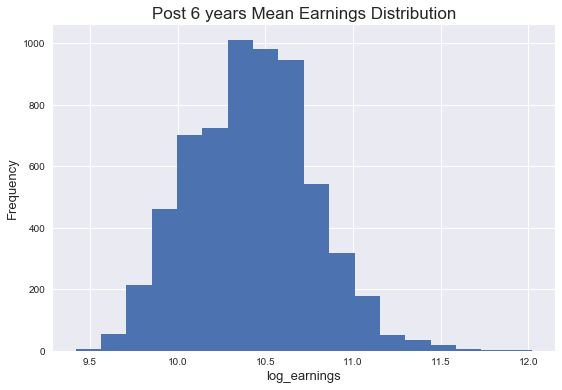

In [46]:
fig, target_hist = plt.subplots(figsize = (9,6))
plt.hist(df_college.MN_EARN_WNE_P10,bins = 18)
plt.title('Post 6 years Mean Earnings Distribution', size = 17)
plt.xlabel('log_earnings', size = 13)
plt.ylabel('Frequency', size = 13)

# roughly normal

### Train test split
I am going to split my dataset into train, test, and validation set first. 

In [47]:
y = df_college.MN_EARN_WNE_P10
X = df_college.drop('MN_EARN_WNE_P10', axis = 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 5555)

### Modeling
Having removed certain collinear variables from the imputation process in R, we still have a relatively large feature space of 435 variables.

We could do a number of things, run a ridge regression to deal with potentially persisting multicollinearity problem that still exists in our dataset   
Please refer :  
http://web.as.uky.edu/statistics/users/pbreheny/764-f11/notes/9-1.pdf

We could also run Lasso for its embedded feature selection methods

In [216]:
def find_alpha(X_train, y_train, n_folds, alphas, l1_ratio = None,):
    '''
    use cross validation method to determine MSE of differnet penalty (alpha) parameters
    in our l2 regularized model.
    
    X_train : feature matrix (dataframe)
    y_train : target_variable (series, np.array, etc..)
    n_folds : number of folds to divide up for cross valdation (int)
    alphas : list of penalty parameter to test out (list)
    return: MSE of different penalty parameters (list)
    '''
    kf = KFold(n=len(X_train), n_folds=n_folds, shuffle=True, random_state=5555)
    alphas=alphas
    all_mse_scores= np.array(len(alphas)*[0.0])

    for train,test in kf:

        X_cv_train= X_train.iloc[train]
        y_cv_train= y_train.iloc[train]
        X_cv_test= X_train.iloc[test]
        y_cv_test= y_train.iloc[test]

        mse_score=[]
        for a in alphas:
            est=Lasso(alpha=a, fit_intercept=False, max_iter=1000, tol = 0.004, normalize = True)
            est.fit(X_cv_train,y_cv_train)
            mse = np.mean((np.array((y_cv_test))-est.predict(X_cv_test))**2)
            mse_score.append(mse)
        all_mse_scores += mse_score

    return all_mse_scores/len(alphas)

In [217]:
find_alpha(X_train, y_train, 5, alphas = [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,])

# let us use 1e-2 as the penalty parameter for Ridge because it gives the lowest mse

array([ 0.01424325,  0.01426117,  0.01419866,  0.01459247,  0.01435109,
        0.01556794,  0.01989129,  0.47526807])

#### Let us define a validation set

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state = 5555)

#### Implementing Ridge Regression

In [49]:
# fitting and checking coef with ElasticNet

rcv = RidgeCV(alphas = [1e-2], fit_intercept = True, cv = 10,)
rcv.fit(X_train, y_train)

# scoring our model on our validation set
print('Ridge')
print('MSE: ' + str(np.mean((rcv.predict(X_valid)-y_valid)**2)))
print('R2: ' + str(rcv.score(X_valid,y_valid)))

Ridge
MSE: 0.020833247939017398
R2: 0.827284375665


#### Implementing Lasso Regression

In [50]:
# fitting and checking coef with Lasso

lcv = LassoCV(alphas = [1e-5], tol=0.07, fit_intercept = True, max_iter=1000)
lcv.fit(X_train, y_train)

# scoring our model on our validation set
print('Lasso')
print('MSE: ' + str(np.mean((lcv.predict(X_valid)-y_valid)**2)))
print('R2: ' + str(lcv.score(X_valid,y_valid)))

Lasso
MSE: 0.02007906371861281
R2: 0.833536852421


#### Implementing ElasticNet

In [51]:
# fitting and checking coef with ElasticNet

encv = ElasticNetCV(l1_ratio=0.5, alphas = [1e-5], fit_intercept = True, tol = 0.1, max_iter=1000)
encv.fit(X_train, y_train)

# scoring our model on our validation set
print('ElasticNet')
print('MSE: ' + str(np.mean((encv.predict(X_valid)-y_valid)**2)))
print('R2: ' + str(encv.score(X_valid,y_valid)))

ElasticNet
MSE: 0.022385231240662114
R2: 0.814417838211


#### Random Forest feature selection through feature importance

In [52]:
from sklearn.model_selection import RandomizedSearchCV

In [53]:
# Grid searching for optimal parameter

rfr = RandomForestRegressor()

# param_dist = dict(max_depth = [10,30,50,70,100], max_features = ['auto','sqrt'])

# rgs = RandomizedSearchCV(rfr, param_dist, cv=10, scoring='neg_mean_squared_error',) 
# rgs.fit(X_train, y_train,)

print(rgs.best_params_)
print(rgs.best_score_)

NameError: name 'rgs' is not defined

In [176]:
rfr = RandomForestRegressor(n_estimators=120,random_state=5555,)
rffit = rfr.fit(X_train, y_train,)

In [55]:
print('Random Forest')
print('R2: ' + str(rfr.score(X_valid,y_valid)))
print('MSE: ' + str(sum((rfr.predict(X_valid) - np.array(y_valid))**2)/len(y_valid)))

Random Forest
R2: 0.862030761456
MSE: 0.0166420806781


In [378]:
# top 20 most importan features

feat_importance = sorted(list(zip(X.columns, rfr.feature_importances_)),key=lambda x : x[1], reverse=True)
pprint(feat_importance[:49])

[('ICLEVEL[T.4_year]', 0.20265168771626929),
 ('PCIP12', 0.15266231496954003),
 ('PREDDEG[T.bachelor]', 0.12417203398775419),
 ('FAMINC', 0.057666034078731318),
 ('DEP_INC_AVG', 0.045110133209228881),
 ('PELL_EVER', 0.033725161084088733),
 ('MD_FAMINC', 0.032244821885035045),
 ('COMP_ORIG_YR4_RT', 0.029764442804288336),
 ('UGDS_ASIAN', 0.027782488485094806),
 ('IND_INC_AVG', 0.022331773076523967),
 ('PCTPELL', 0.015595476685164318),
 ('INC_PCT_LO', 0.014211392634801293),
 ('PREDDEG[T.certificate]', 0.012493966790531308),
 ('INEXPFTE', 0.011280126551081741),
 ('COUNT_WNE_P10', 0.010411610021189116),
 ('FEMALE', 0.0085051110340020174),
 ('DEP_STAT_PCT_IND', 0.0071784839060488196),
 ('PCIP14', 0.0059841838683815894),
 ('UGDS', 0.0057340828819384326),
 ('COUNT_WNE_INC2_P10', 0.0053592101943376602),
 ('CDR2', 0.0053591683654925426),
 ('UGDS_WOMEN', 0.005185451704796621),
 ('UGDS_MEN', 0.0050356121394431871),
 ('UGDS_BLACK', 0.0047536044631672362),
 ('WDRAW_ORIG_YR2_RT', 0.004631574404780096

### Taking the top features ranked according to feature importance

I want to do some inference with regards to the explanatory power of the most importan variable in my Random Forest model. I am aware that because tree models are able to capture non-linear relationship, predictors that it deemed important may not be have a linear relationship with the target variable. Therefore, some trnasformation adn tweeking may be required when fine tuning the regression model.

Another potential source of problem is that taking this amount of variable, some of them are highly liekly to be strng correlated with one another, leading us into the trap hole of multicollinearity, inflating our stnadard error, which will 'inaccuratize' the estimated coefficient p-value. Therefore, we need to remove some potentially highly correlated predictor variables before proceeding to model

In [251]:
# sns.pairplot(pd.concat([X_train[top15],y_train],axis = 1))
# f, ax = plt.subplots(figsize=(20, 16))
# sns.heatmap(pd.concat([X_train[top15],y_train], axis = 1).corr(method = 'pearson'), linewidths=0.25,vmax=1.0, square=True, linecolor='black', annot=True)

In [241]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [384]:

def multicollinearity_remover(predictor, target, threshold):
    '''
    remove predictor variables that have to a variance inflation factor above threshold
    
    predictor : predictor varaibles (matrix, dataframe etc.)
    target : target variable vector (series, list, etc.)
    threshold : a number above which a predictor variable will be deemed highly collinear with other predictor
                and be dropped from final predictor matrix (int,float)
    return : a predictor matrix with highly collinear varaibles dropped
    '''
    vifs = [threshold]
    predictor_c = predictor.copy()
    
    model = sm.GLM(target, predictor_c)
    result = model.fit()
    
    while list(filter(lambda x : x >= threshold, vifs)):
    
        predictor_name = pd.Series(result.params).index
        current_vifs = []
        for i in range(1,len(predictor_name)):
            vif = variance_inflation_factor(result.model.exog, i)
            current_vifs.append(vif)

        vifs = current_vifs

        # index of variable with highest vif
        max_index = current_vifs.index(max(current_vifs))

        # remove that variable
        predictor_c = predictor_c.drop(predictor_name[max_index + 1], axis = 1)

        model = sm.OLS(target, predictor_c)
        result = model.fit()
               
       
    return predictor_c
               
               
               
               

In [370]:
multicollinearity_remover(standardize(X_train[top20],['PREDDEG','HIGHDEG','CONTOL','REGION','ICLEVEL','ISNULL','EARN','INTERCEPT']), y_train, 5)

,INTERCEPT,PCIP12,PREDDEG[T.bachelor],PELL_EVER,COMP_ORIG_YR4_RT,UGDS_ASIAN,IND_INC_AVG,PCTPELL,PREDDEG[T.certificate],INEXPFTE,COUNT_WNE_P10,FEMALE,DEP_STAT_PCT_IND,PCIP14,UGDS
3135,1,-0.469485,0.0,-0.225966,-1.280375,0.154592,0.537862,-0.783084,0.0,-0.220270,-0.053750,-0.332764,-0.298308,-0.058295,1.557100
1727,1,-0.469485,1.0,-1.728734,-0.456400,0.005590,0.984734,-1.205044,0.0,0.059486,-0.127465,-0.221117,-1.471042,-0.167492,0.301898
2153,1,2.322517,0.0,0.080040,0.571303,-0.200840,-0.051487,0.373089,1.0,-0.217354,-0.270222,1.439205,-0.291800,-0.167492,-0.388145
393,1,2.278682,0.0,0.885032,0.751743,0.052153,-0.955477,1.025129,1.0,-0.403018,-0.201632,1.419889,0.268036,-0.167492,-0.005792
5391,1,-0.469485,0.0,-2.388412,0.745165,-0.466249,1.287724,-1.090005,1.0,-0.543492,-0.210285,1.436953,0.585590,-0.167492,-0.398959
3277,1,-0.469485,0.0,-2.160622,0.909515,-0.188423,0.554768,0.523662,0.0,0.148673,0.682349,-0.637773,-1.871082,-0.167492,-0.339406
5277,1,-0.469485,0.0,0.737729,-0.764557,-0.436759,-0.377682,1.472407,1.0,-0.413090,-0.111184,-0.670147,0.864659,-0.167492,-0.327999
5706,1,0.128282,0.0,0.849930,0.090071,-0.371571,-0.429223,0.977603,1.0,-0.379164,-0.259369,1.125681,1.039640,-0.167492,-0.332888
1270,1,1.644339,0.0,-0.088762,1.893566,-0.326560,-0.105270,0.325118,1.0,-0.568804,-0.277308,1.470339,-0.285073,-0.167492,-0.389034
5881,1,2.322517,0.0,0.602324,0.877874,-0.183767,-0.840496,1.186362,1.0,-0.303229,-0.238415,1.496807,0.355002,-0.167492,-0.389182


In [383]:
top20 = list(map(lambda x : x[0], feat_importance[:19]))
top20.insert(0,'INTERCEPT')

In [381]:
# lr = sm.OLS(((np.exp(y_train) - np.mean(np.exp(y_train)))/np.std(np.exp(y_train))), X_train[top12])
lr = sm.OLS(y_train, multicollinearity_remover(multicollinearity_remover(standardize(X_train[top20],['PREDDEG','HIGHDEG','CONTOL','REGION','ICLEVEL','ISNULL','EARN','INTERCEPT']), y_train, 5), y_train, 8))

In [382]:
result = lr.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MN_EARN_WNE_P10   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     501.1
Date:                Sat, 02 Sep 2017   Prob (F-statistic):               0.00
Time:                        10:26:00   Log-Likelihood:                 1545.6
No. Observations:                3513   AIC:                            -3035.
Df Residuals:                    3485   BIC:                            -2863.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
INTERCEPT                 10.4279      0.007   1441.456      0.000      10.414      10.442
ICLEVEL[T.4_year]          0.0520      0.011      4.772      0.000       0.031       0.073
PCIP12                    -0.0994      0.003    -28.873      0.000      -0.106      -0.093
PREDDEG[T.bachelor]       -0.0044      0.012     -0.379      0.705      -0.027       0.019
UGDS_ASIAN                 0.0316      0.003     11.084      0.000       0.026       0.037
IND_INC_AVG                0.0803      0.004     20.487      0.000       0.073       0.088
PCTPELL                   -0.0462      0.004    -12.072      0.000      -0.054      -0.039
PREDDEG[T.certificate]    -0.0555      0.009     -6.131      0.000      -0.073      -0.038
INEXPFTE                   0.0464      0.003     15.218      0.000       0.040       0.052
PCIP14                     0.0308      0.003     10.929      0.000       0.025       0.036
UGDS                       0.0114      0.003      3.849      0.000       0.006       0.017
CDR2                       0.0057      0.004      1.427      0.154      -0.002       0.014
UGDS_WOMEN                -0.0586      0.003    -16.875      0.000      -0.065      -0.052
UGDS_BLACK                 0.0040      0.003      1.213      0.225      -0.002       0.011
WDRAW_ORIG_YR2_RT          0.0097      0.004      2.650      0.008       0.003       0.017
CDR3                      -0.0066      0.004     -1.585      0.113      -0.015       0.002
COMP_ORIG_YR6_RT           0.0605      0.004     16.423      0.000       0.053       0.068
PCIP50                    -0.0239      0.003     -8.299      0.000      -0.030      -0.018
INC_PCT_M1                 0.0127      0.003      3.648      0.000       0.006       0.020
UGDS_HISP                 -0.0019      0.003     -0.605      0.545      -0.008       0.004
COUNT_WNE_MALE0_P10        0.0583      0.003     17.938      0.000       0.052       0.065
MARRIED                   -0.0256      0.004     -6.176      0.000      -0.034      -0.017
TUITFTE                    0.0225      0.003      6.585      0.000       0.016       0.029
AGE_ENTRY                  0.0112      0.005      2.280      0.023       0.002       0.021
APPL_SCH_PCT_GE2           0.0423      0.004     10.013      0.000       0.034       0.051
COUNT_WNE_INDEP0_P10       0.0089      0.003      2.860      0.004       0.003       0.015
PPTUG_EF                   0.0222      0.003      6.494      0.000       0.015       0.029
UGDS_UNKN                  0.0122      0.003      4.117      0.000       0.006       0.018
==============================================================================
Omnibus:                      151.824   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              407.606
Skew:                    

In [376]:
params = pd.Series(result.params)
for i in range(1,len(params)):
    print(params.index[i])
    print(np.std(X_train[top20][params.index[i]]))
    print(params[i])
    params[i] = params[i] * np.std(X_train[top20][params.index[i]])


PCIP12
0.3581149522982143
-0.0333365692193
PREDDEG[T.bachelor]
0.4708988937853987
0.0800237247076
COMP_ORIG_YR4_RT
0.2138693781933767
0.060337982025
UGDS_ASIAN
0.0644196048892392
0.0321001313011
IND_INC_AVG
8842.194842124121
0.0895137580997
PCTPELL
0.22510738875597874
-0.0504523572945
PREDDEG[T.certificate]
0.4954083407335203
-0.115646960922
INEXPFTE
7544.812118971085
0.0484120098415
COUNT_WNE_P10
6632.678674587419
0.0662260278496
FEMALE
0.19946834241481348
-0.0524976656464
DEP_STAT_PCT_IND
0.23549014946394894
0.00172047730075
PCIP14
0.05127610213687764
0.0312264513244
UGDS
6749.347380874676
0.0162099119867


In [377]:
params

INTERCEPT                  10.447874
PCIP12                     -0.011938
PREDDEG[T.bachelor]         0.037683
COMP_ORIG_YR4_RT            0.012904
UGDS_ASIAN                  0.002068
IND_INC_AVG               791.498090
PCTPELL                    -0.011357
PREDDEG[T.certificate]     -0.057292
INEXPFTE                  365.259519
COUNT_WNE_P10             439.255963
FEMALE                     -0.010472
DEP_STAT_PCT_IND            0.000405
PCIP14                      0.001601
UGDS                      109.406327
dtype: float64

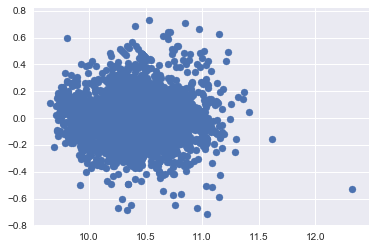

In [201]:
plt.scatter(result.predict(X_train[top15]), result.resid)